In [1]:
import pandas as pd
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
%matplotlib inline  

plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = "bold"
mpl.rcParams["axes.titlelocation"] = "left"
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.titleweight'] = "bold"

plt.rcParams["figure.figsize"] = (8,4)

# Inledning



Laddbara bilar slår försäljningsrekord, men vad betyder det för de svenska klimatmålen? 

I det här PM:et analyserar vi förutsättningarna att nå 2030-målen om 70 procents reduktion från transportsektorn, samt hur 2030-målen förhåller sig till Parisavtalets utsläppsutrymme.

Slutsatserna ligger till grund för artiklar på Newsworthy.se och DI.se i maj 2021.

Författare: Jens Finnäs (jens@newsworthy.se)

# En enkel modell för att räkna personbilarnas CO2-utsläpp

För att räkna ut personbilssektorns samlade utsläpp använder vi samma modell som Jonas Eliasson och BIL Sweden i sin färdplan för fossilfria transporter.

Den är baserade på följande parametrar:

1. Det samlade trafikarbetet (dvs hur många kilometer alla bilar kör).
2. Hur stor andel av trafikarbetet nya och gamla bilar står för.
3. Nya personbilars förväntad utsläpp (g/km)


## 1. Trafikarbete – nu och framåt

År 2020 var ett speciellt år. Trafikarbetet minskade kraftigt under pandemin. Det gör kommande års prognoser svårare att göra. Kommer bilkörandet återgå till samma nivå (och tillväxttakt) som tidigare? Eller kommer vanorna förändras mer permanent?

I den här modellen antar vi att trafikarbete år 2021 kommer vara längre än normalt på grund av coronapandemin. Därefter antar vi att personbilstrafiken återgår till samma nivå som år 2019 med en årlig tillväxt på **1,0 procent**. Det är den samma ökningstakt som [Trafikverket räknar med](http://trafikverket.diva-portal.org/smash/get/diva2:1484841/FULLTEXT01.pdf) (sid 10).



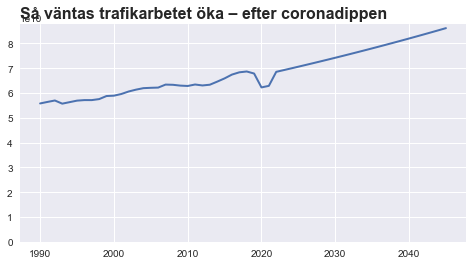


Det innebär en sammalagd ökning 2019–2030 på 18%. Vårt scenario kommer utgå från detta.


In [2]:


TRAFIC_WORK_GROWTH_RATE = 1.01

# som miljoner fordons-km
s_traffic_work = pd.read_excel("../data/trafikarbete-pa-svenska-vagar-1990-2020.xls",
                              sheet_name="Trafikarbete", skiprows=3)\
.iloc[4:,:].rename(columns={"År": "year"}).set_index("year")["Personbil"] * 1e6
s_traffic_work.index = [year if isinstance(year, int) else int(year.replace("p", ""))
                        for year in s_traffic_work.index]

s_traffic_work.index = s_traffic_work.index.astype(int)



for year in range(s_traffic_work.index[-1] + 1, 2045 + 1):
    year_to_compare = year - 1
    if year == 2022:
        year_to_compare = 2019

    s_traffic_work[year] = s_traffic_work[year_to_compare] * TRAFIC_WORK_GROWTH_RATE

growth = s_traffic_work.loc[2030] / s_traffic_work.loc[2010] - 1


ax = s_traffic_work.plot(title="Så väntas trafikarbetet öka – efter coronadippen")
ax.set_ylim(0)
plt.show()

md(f"""
Det innebär en sammalagd ökning 2019–2030 på {growth:.0%}. Vårt scenario kommer utgå från detta.
""")



Men vi kommer även räkna med ett scenario där trafikarbetet stannar på 2019-nivå, utan tillväxt. Det scenariot kommer se ut så här:

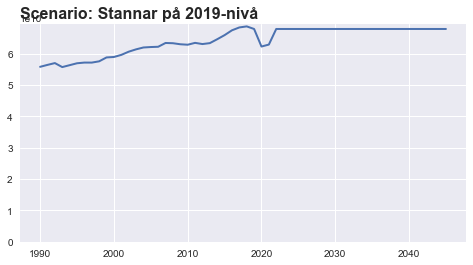

In [3]:
s_traffic_work_low = s_traffic_work.copy()
for year in range(2022, 2045+1):
    s_traffic_work_low.loc[year] = s_traffic_work.loc[2019]

ax = s_traffic_work_low.plot(title="Scenario: Stannar på 2019-nivå")
ax.set_ylim(0)
plt.show()


## 2. Hur stor andel av trafikarbetet står nya och gamla bilar för?

Från BIL Sweden (Jonas Eliasson) har vi fått uppgifter om fördelningen av bilar per årsmodell år 2016, samt fördelningen deras andel av det totala trafikarbetet.


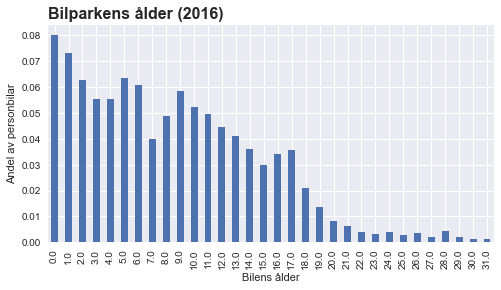

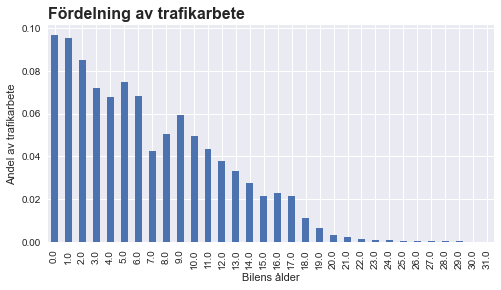

In [4]:

df_per_car_age = pd.read_excel("../data/Jonas Eliasson - Nyckeltal från BIL Swedens färdplan.xls")[["årsmodell", "antal bilar", "mil/bil (kursivt = imputerade data)"]]\
.rename(columns={"antal bilar": "n_cars", "mil/bil (kursivt = imputerade data)": "km_per_car"})
df_per_car_age["car_age"] = (2016 - df_per_car_age["årsmodell"])
df_per_car_age = df_per_car_age[df_per_car_age["car_age"].notna()]\
.set_index("car_age").drop("årsmodell", axis=1)

df_per_car_age["km_per_car"] = df_per_car_age["km_per_car"] * 10 # mil => km
df_per_car_age["milage"] = df_per_car_age["km_per_car"] * df_per_car_age["n_cars"]
df_per_car_age["share_of_count"] = df_per_car_age["n_cars"] / df_per_car_age["n_cars"].sum()
df_per_car_age["share_of_mileage"] = df_per_car_age["milage"] / df_per_car_age["milage"].sum()
ax = df_per_car_age["share_of_count"].sort_index().plot.bar(title="Bilparkens ålder (2016)")
ax.set_xlabel("Bilens ålder")
ax.set_ylabel("Andel av personbilar")
plt.show()

ax = df_per_car_age["share_of_mileage"].sort_index().plot.bar(title="Fördelning av trafikarbete")
ax.set_xlabel("Bilens ålder")
ax.set_ylabel("Andel av trafikarbete")
plt.show()

Vi kommer att anta att den här fördelningen är kostant över tid, det vill säga att att äldre bilar fasas ut från vägarna i samma takt som i dag.

## 3. Personbilarnas utsläpp

Nya personbilarna släpper ut betydligt mindre än äldre. Under 2020 gjordes att en särskilt stor dipp.

Data om utsläpp per årsmodell kommer Transportanalys, kompletterat av äldre data från BIL Sweden/Jonas Eliasson.

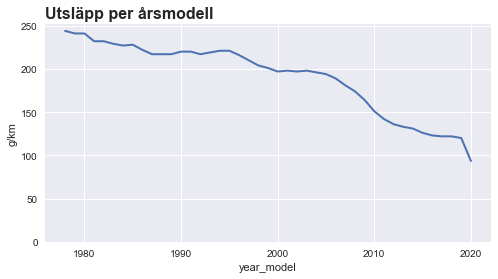

In [5]:
s_co2_by_year_model = pd.read_excel("../data/Jonas Eliasson - Nyckeltal från BIL Swedens färdplan.xls")\
.rename(columns={"Årsmodell": "year_model", "CO2 g/km bränslebilar": "co2_per_km"})\
.set_index("year_model")["co2_per_km"]
ax = s_co2_by_year_model.plot(title="Utsläpp per årsmodell")
ax.set_ylim(0)
ax.set_ylabel("g/km")
plt.show()

## Så räknar vi CO2-utsläpp

Med dessa tre pusselbitar på plats kommer vi att räkna ut det total koldioxidutsläppen som:

`totalt vägarbete` * `andel av vägarbete per årsmodell` * `utsläpp per årsmodell`

Vi kan testa modellen genom att jämföra den mot observerade utsläpp (hämtade från [Naturvårdsverket](https://www.naturvardsverket.se/Sa-mar-miljon/Statistik-A-O/Vaxthusgaser-utslapp-fran-inrikes-transporter/)):



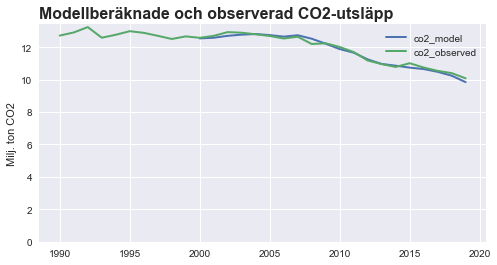

In [6]:
def compute_total_co2(year, s_co2_by_ym, s_tw_by_year):
    s_tw_by_year = df_per_car_age["share_of_mileage"].copy() * s_tw_by_year.loc[year]
    s_tw_by_year.index = [int(year - x) for x in s_tw_by_year.index]

    co2 = (s_tw_by_year * s_co2_by_ym).sum() / 1e12

    return co2
    
years = range(2000,2020)
co2_modeled = pd.Series(years, index=years)\
                .apply(compute_total_co2, args=(s_co2_by_year_model, s_traffic_work))\
                .rename("co2_model")
co2_observed = pd.read_csv("../data/naturvårdsverket - vaxthusgaser-utslapp-inrikes-transp-1990-2019.csv")\
               .set_index("Unnamed: 0")\
               .loc["Bilar"]\
                .rename("co2_observed") / 1000
co2_observed.index = co2_observed.index.astype(int)
ax  = pd.concat([co2_modeled, co2_observed], axis=1).plot(title="Modellberäknade och observerad CO2-utsläpp")
ax.set_ylim(0)
ax.set_ylabel("Milj. ton CO2")
plt.show()


# Hur mycket koldioxid sparade pandemin in?

Trafikarbetet gick alltså kraftigt ner under pandemin. Hur mycket koldioxid besparades atmosfären? Här skattar vi 2020 års personbilsutsläpp baserat på dels det faktiska, dels det förväntade trafikarbetet. Utan pandemin antas vi ha kört något bil något mer under 2020 än 2019.



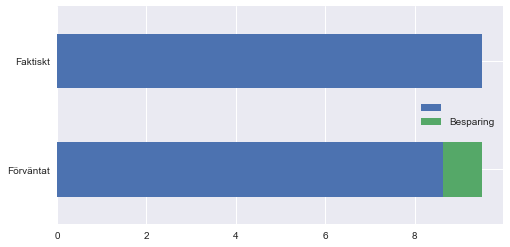

In [7]:
# Faktiskt trafikarbete 
s_traffic_work_real = s_traffic_work

# Förväntat trafikarbete
s_traffic_work_exp = pd.Series(s_traffic_work.loc[2019] * TRAFIC_WORK_GROWTH_RATE, index=[2020])

co2_on_real_traffic_work_2019 = compute_total_co2(2019, s_co2_by_year_model, s_traffic_work)
co2_on_real_traffic_work = compute_total_co2(2020, s_co2_by_year_model, s_traffic_work)
co2_on_expected_traffic_work = compute_total_co2(2020, s_co2_by_year_model, s_traffic_work_exp)
diff = co2_on_expected_traffic_work - co2_on_real_traffic_work

labels = ["Förväntat", "Faktiskt"]
pd.concat([
    pd.Series([co2_on_real_traffic_work, co2_on_expected_traffic_work], index=labels).rename(""),
    pd.Series([diff, 0], index=labels).rename("Besparing"),
], axis=1).plot.barh(stacked=True, title="")
plt.show()

In [8]:
co2_decline = co2_on_real_traffic_work/co2_on_real_traffic_work_2019 -1
md(f"""
Vår modell uppskattar att koldioxidutsläppen från personbilar landade på omkring 
**{co2_on_real_traffic_work:.2} miljoner ton** år 2020. Det är 
{co2_decline:.0%} procent mindre än året innan.

Om trafikarbetet däremot hade fortsatt öka i samma takt som tidigare hade utsläppen 
landat på omkring **{co2_on_expected_traffic_work:.2} miljoner ton**. 
Pandemin har med andra ord besparat oss cirka **{diff:.1} miljoner ton** CO2-utsläpp från personbilstrafiken.  
""")


Vår modell uppskattar att koldioxidutsläppen från personbilar landade på omkring 
**8.6 miljoner ton** år 2020. Det är 
-12% procent mindre än året innan.

Om trafikarbetet däremot hade fortsatt öka i samma takt som tidigare hade utsläppen 
landat på omkring **9.5 miljoner ton**. 
Pandemin har med andra ord besparat oss cirka **0.9 miljoner ton** CO2-utsläpp från personbilstrafiken.  


# Klarar vi transportsektorns 2030-mål med nuvarande försälningstakt av laddbara bilar?

Hela transportsektorns mål är att minska utsläppen med 70 procent i förhållande till 2010 års utsläpp till år 2030 och uppnå koldioxidneutralitet år 2045. Det skulle innebära ungefär följande utsläppsbana om vi antar en jämn, årlig minskning.

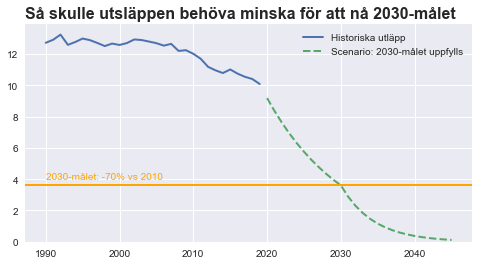

In [9]:
latest_oberved_year = co2_observed.index.max()
first_modeled_year = latest_oberved_year + 1
last_modeled_year = 2045
modeled_years = [x for x in range(first_modeled_year, last_modeled_year + 1)]

co2_2010 = co2_observed.loc[2010]
co2_latest_obeserved = co2_observed.iloc[-1]
co2_klimatmålet_2030 = co2_2010 * 0.3
co2_klimatmålet_2045 = co2_2010 * 0.01


df_co2_proj = pd.DataFrame(index=modeled_years)

n_years_to_2030 = 2030 - latest_oberved_year
yearly_change_to_meet_2030 = pow(co2_klimatmålet_2030 / co2_latest_obeserved, 1 / n_years_to_2030)
yearly_change_to_meet_2045 = pow(co2_klimatmålet_2045 / co2_klimatmålet_2030, 1 / 15)


yearly_emissions = pd.concat([
    pd.Series([yearly_change_to_meet_2030] * n_years_to_2030).cumprod() * co2_latest_obeserved,
    pd.Series([yearly_change_to_meet_2045] * 15).cumprod() * co2_klimatmålet_2030,
]) 
yearly_emissions.index = modeled_years

df_co2_proj["jämn minskning mot klimatmålet 2030"] = yearly_emissions

def plot_scenarios(scenarios):
    ax = co2_observed.plot(label="Historiska utläpp")
    
    for s_scen, label in scenarios:
        s_scen.plot(ax=ax, linestyle="dashed", label=label)

    ax.set_ylim(0)

    plt.text(1990, co2_klimatmålet_2030 + 0.4, "2030-målet: -70% vs 2010", c="orange")
    ax.axhline(co2_klimatmålet_2030, c="orange")

    ax.legend()
    
    return ax


ax = plot_scenarios([
    (df_co2_proj["jämn minskning mot klimatmålet 2030"], "Scenario: 2030-målet uppfylls"),
])
ax.set_title("Så skulle utsläppen behöva minska för att nå 2030-målet")
plt.show()

Låt oss nu titta på hur några olika scenarier för laddbilsförsäljning skulle falla ut i förhållande till detta basscenario. 

## Scenario 1: Bara elbilar

Som ett först testa räknar vi på vad som händer om vi från och med nu säljer *bara* rena elbilar. Vi antar alltså att alla nyregistrerade fordon har noll utsläpp.

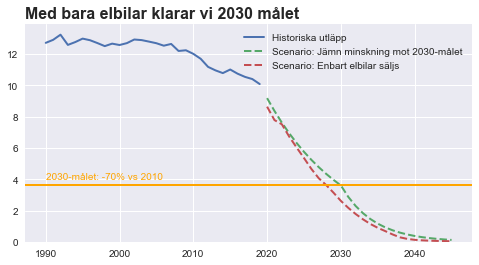

In [10]:
_ = s_co2_by_year_model.copy()

s_electronic_only = _.append(pd.Series(index=range(_.index.max() + 1, last_modeled_year), dtype=float).fillna(0))

co2_electronic_only = pd.Series(modeled_years, index=modeled_years)\
                .apply(compute_total_co2, args=(s_electronic_only, s_traffic_work,))\
                .rename("co2_electronic_only")

df_co2_proj["bara elbilar"] = df_co2_proj.index.map(lambda x: compute_total_co2(x, s_electronic_only, s_traffic_work,))

ax = plot_scenarios([
    (df_co2_proj["jämn minskning mot klimatmålet 2030"], "Scenario: Jämn minskning mot 2030-målet"),
    (df_co2_proj["bara elbilar"], "Scenario: Enbart elbilar säljs"),
])
ax.set_title("Med bara elbilar klarar vi 2030 målet")
plt.show()

In [11]:
_co2_2030 = df_co2_proj["bara elbilar"].loc[2030]
_diff = _co2_2030 - co2_klimatmålet_2030 
_reduction_2010 = _co2_2030 / co2_2010 - 1

md(f"""
Om alla nya bilar var helt utsläppsfria skulle vi år 2030 släppa ut 
{_co2_2030:.2} miljoner ton CO2, {_reduction_2010:.0%} procent mindre än 2010 och därmed {_diff:.2} miljoner ton mindre än klimatmålet som uppfylls. 
""")


Om alla nya bilar var helt utsläppsfria skulle vi år 2030 släppa ut 
2.6 miljoner ton CO2, -78% procent mindre än 2010 och därmed -0.99 miljoner ton mindre än klimatmålet som uppfylls. 


## Scenario 2: Gradvis ökning

I verkligheten kommer det så klart fortsätta säljas fossildrivna bilar, även om laddbart ökar snabbt. Vi räknar här på två scenarier:

1) Laddabara bilar utgör **65 procent** av föräljningen år 2030 och **90 procent** år 2045.

2) Laddabara bilar utgör **90 procent** av föräljningen år 2030 och **95 procent** år 2045.


Vi gör samma antagande som [Fossilfritt Sveriges färdplans](https://fossilfrittsverige.se/wp-content/uploads/2020/09/Fardplan_Latta-fordon.pdf) att nya fordon effektiveras med 1,5 procent per år (figur 9). 

"Laddbara bilar" består av både laddbyhrider och rena elbilar. Laddbyhdriderna antas [släppa ut 40 gram/km](https://www.transportstyrelsen.se/sv/vagtrafik/statistik/Statistik-over-koldioxidutslapp/statistik-over-koldioxidutslapp-2020/).

65 procent laddbara är i linje med [Trafikverkets scenarier](https://trafikverket.ineko.se/Files/en-US/74700/Ineko.Product.RelatedFiles/2020_080_scenarier_for_att_na_klimatmalet_for_inrikes_transporter_ett_regeringsuppdrag.pdf) (se sid 26). Det andra scenariet får anses väldigt optimistiskt.

Följande bild visar hur utsläppen från **nya bilar** antas utvecklas i de olika scenarierna. 

Formen på kurvorna (framför allt efter 2030) är uppenbart orealistisk, men för den här analysen nöjer vi oss med den yxigheten då det inte påverkar den större bilden i någon betydande utsträckning. 




In [12]:
###
# Antaganden
###

# hur mycket effektivare blir fossilbilar?
fossil_car_efficienct_increase = 0.015

# hur stor andel av laddbara är hybrider?
phev_share_base = 0.7 # 2020, helår
phev_share_2030 = 0.1 # höftning, ingen riktig källa på det
phev_share_2045 = 0

# hur mycket antas laddhybrider släppa ut? 
# vi räknar inte med nån effektivisering
phev_emissions = 40.0 # g/km

# hur stor andel av alla bilar är laddbara?
el_car_share_base = 0.31 # 2020, helår
el_car_share_2030 = 0.65
el_car_share_2045 = 0.9
el_car_share_2030_high = 0.9
el_car_share_2045_high = 0.95

### slut på antaganden

# setup df
latest_year_with_co2_by_year_model = s_co2_by_year_model.index.max()
base_year = latest_year_with_co2_by_year_model
years = range(base_year + 1, 2045 + 1)
df_new_car_emissions = pd.DataFrame(index=years)
df_new_car_emissions["_i"] = range(0, len(years))

after_2030 = df_new_car_emissions.index > 2030
up_to_2030 = df_new_car_emissions.index <= 2030
n_years_to_2030 = 2030 - base_year


# utsläpp för nya fossibilar
df_new_car_emissions["fossil_cars"] = df_new_car_emissions["_i"].apply(lambda x: pow(1 - fossil_car_efficienct_increase, x) * _.loc[latest_year_with_co2_by_year_model]) 


# utläpp för laddhybrider
df_new_car_emissions["phev"] = phev_emissions

# andel laddbyhrider av elbilar
df_new_car_emissions.loc[up_to_2030, "phev_share"] =  df_new_car_emissions[up_to_2030]["_i"].apply(lambda x: phev_share_base - (x + 1) / n_years_to_2030 * (phev_share_base - phev_share_2030)) 
df_new_car_emissions.loc[after_2030, "phev_share"] =  df_new_car_emissions[after_2030]["_i"].apply(lambda x: phev_share_2030 - (x + 1 - n_years_to_2030) / (2045 - 2030) * (phev_share_2030 - phev_share_2045)) 


# tillväxttaxt för elbilar
el_car_growth = pow(el_car_share_2030 / el_car_share_base, 1 / (n_years_to_2030))
el_car_growth_high = pow(el_car_share_2030_high / el_car_share_base, 1 / (n_years_to_2030))

el_car_growth_after_2030 = pow(el_car_share_2045 / el_car_share_2030, 1/15)
el_car_growth_after_2030_high = pow(el_car_share_2045_high / el_car_share_2030_high, 1/15)

df_new_car_emissions.loc[~after_2030, "el_car_growth"] = el_car_growth
df_new_car_emissions.loc[after_2030, "el_car_growth"] = el_car_growth_after_2030
df_new_car_emissions.loc[~after_2030, "el_car_growth_high"] = el_car_growth_high
df_new_car_emissions.loc[after_2030, "el_car_growth_high"] = el_car_growth_after_2030_high

# elbilarnas andel av alla bilar
df_new_car_emissions["el_car_share"] = df_new_car_emissions["el_car_growth"].cumprod() * el_car_share_base
df_new_car_emissions["el_car_share_high"] = df_new_car_emissions["el_car_growth_high"].cumprod() * el_car_share_base

# utsläpp från alla elbilar
df_new_car_emissions["el_car"] = df_new_car_emissions["phev_share"] * df_new_car_emissions["phev"]



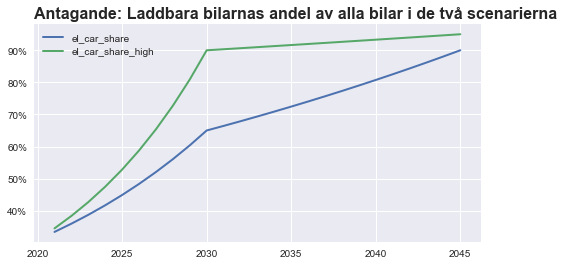

In [13]:
import matplotlib.ticker as mtick

title = "Antagande: Laddbara bilarnas andel av alla bilar i de två scenarierna"
ax = df_new_car_emissions[["el_car_share", "el_car_share_high"]].plot(title=title)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

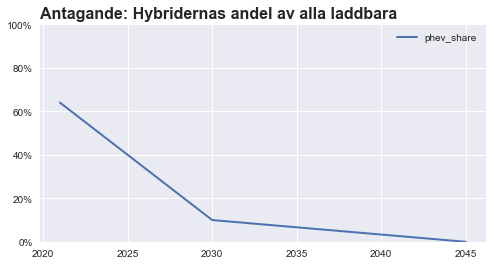

In [14]:
title = "Antagande: Hybridernas andel av alla laddbara"
ax = df_new_car_emissions[["phev_share"]].plot(title=title)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylim(0,1)
plt.show()

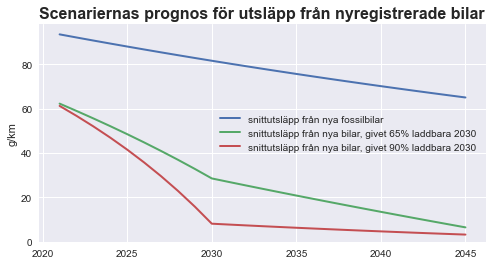

In [15]:

df_new_car_emissions["all_new_cars"] = df_new_car_emissions["fossil_cars"] * (1 - df_new_car_emissions["el_car_share"])
df_new_car_emissions["all_new_cars_high"] = df_new_car_emissions["fossil_cars"] * (1 - df_new_car_emissions["el_car_share_high"])

ax = df_new_car_emissions[["fossil_cars", "all_new_cars", "all_new_cars_high"]]\
.rename(columns={"fossil_cars": "snittutsläpp från nya fossilbilar", 
                 "all_new_cars": f"snittutsläpp från nya bilar, givet {el_car_share_2030:.0%} laddbara 2030",
                 "all_new_cars_high": f"snittutsläpp från nya bilar, givet {el_car_share_2030_high:.0%} laddbara 2030",
                }

       )\
.plot(title="Scenariernas prognos för utsläpp från nyregistrerade bilar")
ax.set_ylim(0)
ax.set_ylabel("g/km")
plt.show()



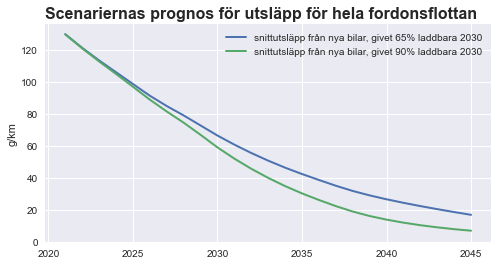

In [16]:
def get_weighted_co2_of_all_cars(year, s_scen):
    # gör en serie av historisk + scenario
    s = s_co2_by_year_model.append(s_scen)
    
    # vikta utifrån fördelning av vägarbete 
    s_share_of_mileage = df_per_car_age["share_of_mileage"].copy()

    # slå ihop serierna (lite osnyggt) 
    y0 = year - df_per_car_age.index.max()
    y1 = year
    s = s[(y0 <= s.index) & (s.index <= y1)]
    s_filtered = s[(y0 <= s.index) & (s.index <= y1)]
    s_share_of_mileage.index = s_filtered.index
    
    # ..och vikta
    return (s_share_of_mileage * s_filtered).sum()

df_new_car_emissions["all_cars"] = [get_weighted_co2_of_all_cars(year, df_new_car_emissions["all_new_cars"])
                                    for year in df_new_car_emissions.index]
df_new_car_emissions["all_cars_high"] = [get_weighted_co2_of_all_cars(year, df_new_car_emissions["all_new_cars_high"])
                                    for year in df_new_car_emissions.index]

ax = df_new_car_emissions[["all_cars", "all_cars_high"]]\
.rename(columns={"all_cars": f"snittutsläpp från nya bilar, givet {el_car_share_2030:.0%} laddbara 2030",
                 "all_cars_high": f"snittutsläpp från nya bilar, givet {el_car_share_2030_high:.0%} laddbara 2030",
                }

       )\
.plot(title="Scenariernas prognos för utsläpp för hela fordonsflottan")
ax.set_ylim(0)
ax.set_ylabel("g/km")
plt.show()




I nästa steg översätter vi dessa scenarier till faktiska utsläpp för hela personbilsflottan. Vi utgår här från att trafikmängden gör en pandemidipp under 2020 och 2021, men att den därefter återgår till samma nivå som år 2019 och sedan fortsätter öka. 

Vi kan se att det dröjer till mitten av 2030-talet innan personbilarna når målet om 70 procents reduktion. Det resterande gapet behöver fyllas igen med biobränslen om målet ska uppnås.


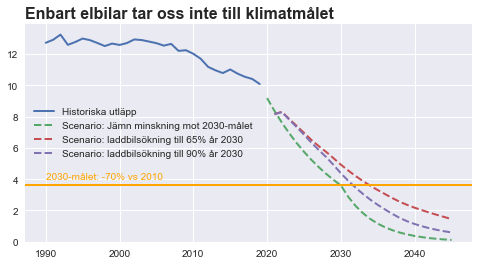

In [17]:

_ = s_co2_by_year_model.copy()
col_name = "laddbilsökning till 65% år 2030"
col_name_high = "laddbilsökning till 90% år 2030"

df_co2_proj[col_name] = pd.Series(years, index=years).apply(compute_total_co2, 
                                                            args=(_.append(df_new_car_emissions["all_new_cars"]),s_traffic_work,)
                                                           )
df_co2_proj[col_name_high] = pd.Series(years, index=years).apply(compute_total_co2, args=(_.append(df_new_car_emissions["all_new_cars_high"]),
                                                                                          s_traffic_work,))

ax = plot_scenarios([
    (df_co2_proj["jämn minskning mot klimatmålet 2030"], "Scenario: Jämn minskning mot 2030-målet"),
    (df_co2_proj[col_name], f"Scenario: {col_name}"),
    (df_co2_proj[col_name_high], f"Scenario: {col_name_high}"),
])
ax.set_title("Enbart elbilar tar oss inte till klimatmålet")
plt.show()

In [18]:
# exportera för att göra grafer
df_co2_proj.to_csv("../data/computed/df_co2_proj.csv")

## Scenario 3: Ingen trafikökning

Vi bygger vidare på föregående två scenarier genom att anta att trafiken *inte* ökar efter år 2022, utan stannar på 2019-nivå. I dessa scenarier *närmar vi oss* 2030-målet, men det dröjer till omkring 2032-2033 innan utsläppen är nere på målnivån om 70 procent reduktion. 

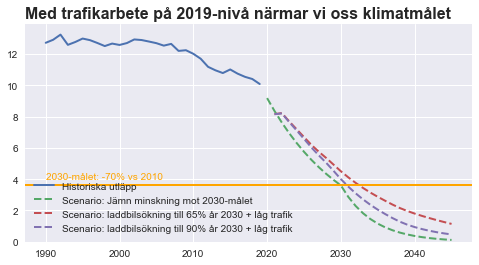

In [19]:
_ = s_co2_by_year_model.copy()
col_name = f"laddbilsökning till 65% år 2030 + låg trafik"
col_name_high = f"laddbilsökning till 90% år 2030 + låg trafik"
df_co2_proj[col_name] = pd.Series(years, index=years).apply(compute_total_co2, 
                                                            args=(_.append(df_new_car_emissions["all_new_cars"]),s_traffic_work_low,)
                                                           )
df_co2_proj[col_name_high] = pd.Series(years, index=years).apply(compute_total_co2, args=(_.append(df_new_car_emissions["all_new_cars_high"]),
                                                                                          s_traffic_work_low,))

ax = plot_scenarios([
    (df_co2_proj["jämn minskning mot klimatmålet 2030"], "Scenario: Jämn minskning mot 2030-målet"),
    (df_co2_proj[col_name], f"Scenario: {col_name}"),
    (df_co2_proj[col_name_high], f"Scenario: {col_name_high}"),
])
ax.set_title("Med trafikarbete på 2019-nivå närmar vi oss klimatmålet")
plt.show()

## Hur många fossilbilar har vi råd att släppa ut?

Det första scenariot där vi räknar med att det *bara* säljs elbilar från och med 2021 utgör samtidigt en baseline för hur mycket den befintliga fordonsparken kan antas släppa ut de närmaste åren. 



In [20]:
# Hur mycket släpper vi ut 2030 om det från och med nu säljs bara elbilar?
co2_2030_with_only_el_cars = df_co2_proj.loc[2030]["bara elbilar"]

# Hur mycket återstående finns det för nya fossilbilar?
remaining_co2_for_fosil_cars = co2_klimatmålet_2030 - co2_2030_with_only_el_cars


md(f"""
I det här scenariot kom vi fram till att klimatmålet 2030 underskrids med {remaining_co2_for_fosil_cars:.2} miljoner 
ton koldioxid. Det här skulle därmed kunna ses som det utsläppsutrymme vi har för *nya* fossilbilar.

För att räkna ut ungefär hur många bilar det motsvarar kommer vi att anta följande:

- Att nya fossildrivna bilar blir gradvis effektivare (samma antagande som tidigare).
- Att trafikmängden fortsätter öka (samma antagande som tidigare).
- Att bilar fasas ut i samma takt som tidigare.
- Att en genomsnittlig bil kör ungefär lika mycket under ett år som i dag (man borde kanske räkna med färre kilometer per år och bil, vilket är trenden, se [Trafikanalys data](https://www.trafa.se/link/7731a0d7166a481cadb7825c6551623f.aspx).
- Att största delen av de nya fossil bilarna kommer säljas de närmaste åren och gradvis trappas ner.
""")


I det här scenariot kom vi fram till att klimatmålet 2030 underskrids med 0.99 miljoner 
ton koldioxid. Det här skulle därmed kunna ses som det utsläppsutrymme vi har för *nya* fossilbilar.

För att räkna ut ungefär hur många bilar det motsvarar kommer vi att anta följande:

- Att nya fossildrivna bilar blir gradvis effektivare (samma antagande som tidigare).
- Att trafikmängden fortsätter öka (samma antagande som tidigare).
- Att bilar fasas ut i samma takt som tidigare.
- Att en genomsnittlig bil kör ungefär lika mycket under ett år som i dag (man borde kanske räkna med färre kilometer per år och bil, vilket är trenden, se [Trafikanalys data](https://www.trafa.se/link/7731a0d7166a481cadb7825c6551623f.aspx).
- Att största delen av de nya fossil bilarna kommer säljas de närmaste åren och gradvis trappas ner.


In [21]:
def get_2030_emissions(year_model):
    """Hur mycket släpper en fossilbil av en given årsmodell ut 2030?
    """
    car_age_2030 = 2030 - year_model
    
    
    # hur mång km kör bilen år 2030?
    # Vi antar här samma körsträckor som i dag (eller rättare sagt 2016 som statistiken från
    # Jonas Eliasson avser). Trenden har dock varit att 
    km_2030 = df_per_car_age.loc[car_age_2030]["km_per_car"] #* trafic_work_increase

    # hur mycket co2 släpper denna årsmodell ut?
    car_co2_per_km = df_new_car_emissions.loc[year_model]["fossil_cars"]

    # g => ton
    return {
        "km_2030": km_2030,
        "car_co2_per_km": car_co2_per_km,
        "2030_emissions": car_co2_per_km * km_2030 / 1e6,
    }

df_emissions_in_2030 = pd.DataFrame(index=range(2021,2031))

# Hur mycket släpper en fossilbil av en given årsmodell ut 2030
df_emissions_in_2030["car_emission_in_2030"] = df_emissions_in_2030.index.map(lambda x: get_2030_emissions(x)["2030_emissions"])

# Vi antar att antalet nya fossilbilarna trappas ner år för år.  
df_emissions_in_2030["distribution"] =  [ 0.5 + (2031 - x) / (2031 - 2021) for x in range(2021,2031)]

# Bilarnas andel av utsläppen kommer bero på 
# a) distributionen av nya bilar per år
# b) hur många km bilar av årsmodellen avverkar 2030
# c) årsmodellens utsläpp
df_emissions_in_2030["share_of_emissions"] = df_emissions_in_2030["car_emission_in_2030"] * df_emissions_in_2030["distribution"]
df_emissions_in_2030["share_of_emissions"] = df_emissions_in_2030["share_of_emissions"] / df_emissions_in_2030["share_of_emissions"].sum()

# Hur många ton co2 kommer bilar av respektive årsmodell släppa ut?
df_emissions_in_2030["total_emissions"] = df_emissions_in_2030["share_of_emissions"] * remaining_co2_for_fosil_cars

# Hur många bilar motsvarar det
df_emissions_in_2030["n_cars"] = df_emissions_in_2030["total_emissions"] * 1e6 / df_emissions_in_2030["car_emission_in_2030"]


n_cars_total = df_emissions_in_2030["n_cars"].sum()
n_cars_total_round = int(round(n_cars_total / 10_000) * 10_000)

example_car_year = 2021
example_car = get_2030_emissions(example_car_year)





md(f"""
Det innebär att en ny fossilbil som rullar ut på vägarna år {example_car_year} 
antas släppa ut **{example_car['car_co2_per_km']} g/km**, köra **{round(example_car['km_2030']):,} km** år 2030 
och därmed släppa ut **{example_car['2030_emissions']:.2} ton koldioxid**.

Med dessa antaganden har vi råd att rulla ut omkring **{n_cars_total_round:,} fossilbilar** för att komma i 
närheten av klimatmålet för 2030.
""")



Det innebär att en ny fossilbil som rullar ut på vägarna år 2021 
antas släppa ut **93.47 g/km**, köra **13,084 km** år 2030 
och därmed släppa ut **1.2 ton koldioxid**.

Med dessa antaganden har vi råd att rulla ut omkring **750,000 fossilbilar** för att komma i 
närheten av klimatmålet för 2030.


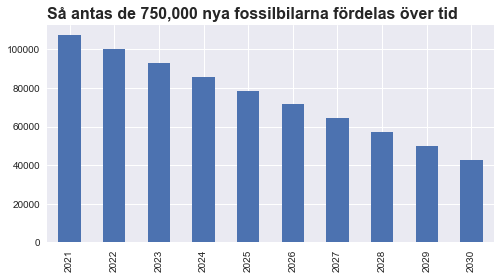

In [22]:
df_emissions_in_2030["n_cars"].plot.bar(title=f"Så antas de {n_cars_total_round:,} nya fossilbilarna fördelas över tid")
plt.show()


Ett annat sätt att formulera den här frågan är *hur länge* vi kan fortsätta rulla ut fossil bilar som i dag och ändå ha en chans att nå 2030-målet. Eller men andra ord: från och med vilket år får vi *bara* sälja elbilar för att ha en chans att minska utsläppen tillräckligt till år 2030?

I den här beräkningarna utgår vi från att:

- Andelen laddbara bilar av nyregistreringar trappas upp i en målbana mot 65 procent år 2030 (se "scenario 2" längre upp)
- Trafikarbetet fortsätter öka med en procent per år.
- Äldre bilar fasas ut i samma takt som i dag.

För varje år mellan 2022 simulerar vi ett omedelbart säljstopp för fossibilar. Det vill säga snittutläpp på 0 g/km för nyregistrerade bilar.

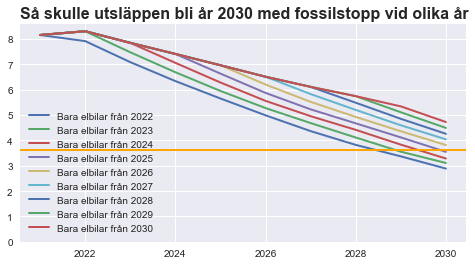

In [50]:
# historiska utsläpp per årsmodell
_ = s_co2_by_year_model.copy()
years = range(2021,2031)
df_el_cars_only_from = pd.DataFrame()
for year in range(2022,2031):
    s = df_new_car_emissions["all_new_cars"].loc[years]
    # noll utsläpp för alla nya bilar
    s[s.index >= year] = 0
    
    # modellberäkna utsläpp
    df_el_cars_only_from[f"Bara elbilar från {year}"] = pd.Series(years, index=years).apply(compute_total_co2, 
                                        args=(_.append(s),s_traffic_work,)
                                        )

title = "Så skulle utsläppen bli år 2030 med fossilstopp vid olika år"    
ax = df_el_cars_only_from.plot(title=title)
ax.axhline(co2_klimatmålet_2030, c="orange")  
ax.set_ylim(0)
plt.show()

Med dessa antaganden skulle vi **omkring år 2025** behöva göra halt för nya fossilbilar för att klara 2030-målet. 

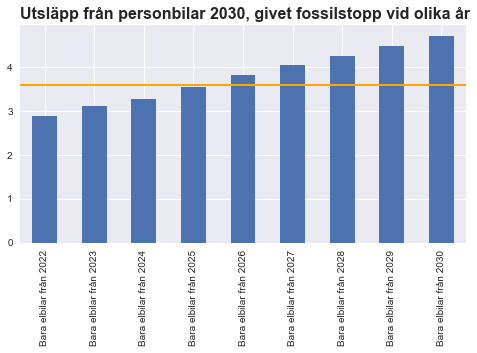

In [53]:
title = "Utsläpp från personbilar 2030, givet fossilstopp vid olika år"
ax = df_el_cars_only_from.loc[2030].plot.bar(title=title)
ax.axhline(co2_klimatmålet_2030, c="orange")  
plt.show()


## Slutsats av scenarierna

Den slutsats man kan dra av dessa scenarier är att det ofrånkomligt dröjer minst 15-20 år att ställa om fordonsflottan till koldioxidneutralitet. Vi är bundna av en fossilskuld i det nuvarande systemet som bara kan hållas tillbaka av minskat bilåkande eller ökad användning av biobränslen. På kort sikt kommer det senare ändå inte att reducera – utan snarare öka – de faktiska koldioxidutsläppen.

# Personbilernas utsläpp i förhållande till CO2-budget

Transportsektorns utsläppsmål är alltså fixerat vid 70 procents reduktion till år 2030 (i förhållande till 2010 års utsläpp). I jämförelse med resten av EU är det här en ambitiös målsättning, men är de målen tillräckliga för att rädda klimatet?

Parisavtalet från 2015 slår fast att världens länder ska försöka begränsa sina utsläpp av växthusgaser så att den globala temperaturhöjningen håller sig under två grader och om möjligt begränsas till 1,5 grader.

Sambandet mellan mängden koldioxid i atmosfären och temperaturhöjningar är väl belagt. Forskare har därmed kunnat räkna ut hur mycket koldioxid var har råd att släppa ut för att ha en rimlig chans att begränsa temperaturhöjningen till två grader. Det här brukar kallas för en koldioxidbudget.

Den här budgeten kan brytas ner och fördelas mellan olika länder. Tar man ländernas historiska utsläpp och ekonomiska förutsättningar i beaktande får Sverige inte släppa ut mer än cirka 300 miljoner ton koldioxid de närmaste decennierna, enligt forskare vid Uppsala universitet.

Vi ska här göra en uppskattning på **personbilstransporternas samlade koldioxidutsläpp** till och med år 2030 och 2045 och jämföra om dessa är i linje med den koldioxidbudget som [Klimatsekrateriatet](https://www.climatevisualizer.com/) (och forskare vid Uppsala universitet) tilldelar personbilstransporterna.

Men är de här målen förenliga med ett budgetperspektiv?


In [41]:
import requests

def get_co2_budget():
    import requests
    URL = "https://storage.googleapis.com/klimatsekretariatet-static/climate-visualizer/sweden/sweden.json"
    r = requests.get(URL)
    json_data = r.json()

    co2_budget = json_data["region"]["budget"]["tCO2"]
    co2_budget_year = json_data["region"]["budget"]["year"]

    total_emissions = json_data["region"]["emissions"]["_sum"]["_sum"][-1]

    # budgeten är räknad med startpunkt i det senaste året med faktiskt redovisade utsläpp
    # vi subtraherar prognosen för det året då vi är intresserade av budget
    # från och med innevarande år
    latest_emission_year = json_data["years"][-1]
    latest_year_subtracted_from_budget = False
    if latest_emission_year == co2_budget_year:
        co2_budget = co2_budget - total_emissions
        co2_budget_year = co2_budget_year + 1
        latest_year_subtracted_from_budget = True


    car_emissions = (json_data["region"]["emissions"]["Inrikes transporter"]["Personbilar"][-1] +
                     json_data["region"]["emissions"]["Inrikes transporter"]["Personbilar (ägarutsläpp)"][-1])
    car_emission_share = car_emissions / total_emissions
    co2_budget_cars = car_emission_share * co2_budget

    return {
        # året som budgeten utgår från
        "budget_year": co2_budget_year,

        # senaste året med rapporterad/prognostiserad data
        "latest_emission_year": latest_emission_year,

        # hela landets co2 budget
        "total_budget": co2_budget   / 1e6 ,

        "car_emissions_latest_year": car_emissions / 1e6,

        # transporternas andel av utsläppen
        "car_emission_share":car_emission_share,

        # transporternas kvarvarande budget
        "budget_cars": co2_budget_cars / 1e6,

        "latest_year_subtracted_from_budget": latest_year_subtracted_from_budget,
    }
budget = get_co2_budget()
co2_budget_year = budget['budget_year']
co2_budget_cars = budget['budget_cars']

md(f"""
Hela landets kvarvarnade CO2-budget för att klara Parisavtalet ligger på {budget['total_budget']:.4} miljoner ton (räknat från och med 1 januari {co2_budget_year}). 

Personbilarna utgör omkring {budget['car_emission_share']:.0%} av de totala utsläppen i Sverige. 
Om vi antar att sektorns del av budgeten är densamma ligger det återstående CO2-utrymmet på 
**{round(budget['budget_cars'])} miljoner ton** koldioxid.
""")



Hela landets kvarvarnade CO2-budget för att klara Parisavtalet ligger på 260.6 miljoner ton (räknat från och med 1 januari 2021). 

Personbilarna utgör omkring 19% av de totala utsläppen i Sverige. 
Om vi antar att sektorns del av budgeten är densamma ligger det återstående CO2-utrymmet på 
**49 miljoner ton** koldioxid.


Nedanstående bilder visar att den här budgeten passeras mellan 2025 och 2030 i samtliga scenarier. Också i det första scenariot där vi uppnår transportsektorns utsläppsmål kommer personbilsflottan släppa ut omkring 70 miljoner ton koldioxid på vägen mot utsläppsfrihet.

I de mer realistiska scenarierna med gradvis ökad elbilsförsäljning släpper personbilarna ut uppemot och över 100 miljoner ton koldioxid till och med år 2045. 

De här kurvorna tar *inte* i beaktande ökad användning av biobränslen. Dessa kommer att redovisas som koldioxidneutrala och sänka kurvorna. Icke desto mindre utgör scenerierna en prognos för hur mycket koldioxid förbränningsmotorerna i den svenska personbilflottan kommer att belasta klimatet med.

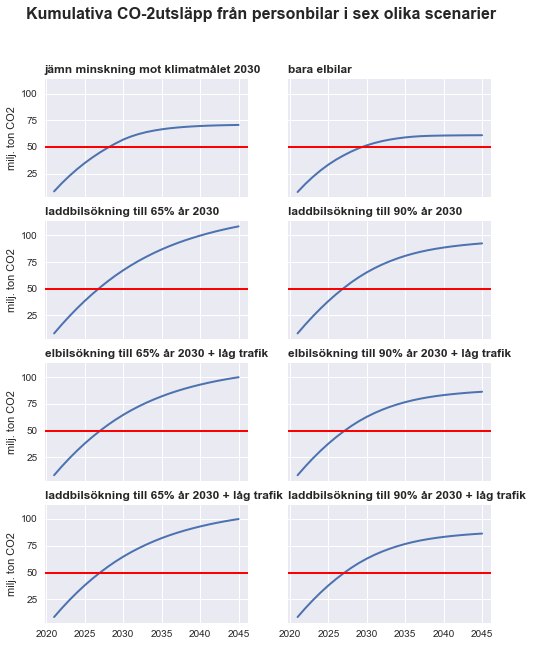

In [42]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(nrows=int(len(df_co2_proj.columns) / 2), ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8,10)
axes = [item for row in axes for item in row]

for scenario, ax in zip(df_co2_proj.columns, axes):
    cum_emissions = df_co2_proj[df_co2_proj.index >= co2_budget_year][scenario].cumsum()
    cum_emissions.plot(ax=ax)
    ax.set_title(scenario, fontsize=12)
    ax.axhline(co2_budget_cars, color="red")
    #plt.text(2021, co2_budget_cars - 1, "Budgettak", color="red", va="top")
    ax.set_ylabel("milj. ton CO2")


fig.suptitle("Kumulativa CO2-utsläpp från personbilar i sex olika scenarier")
plt.show()
    

In [ ]:
# exportera för att göra grafer
df_co2_proj.to_csv("../data/computed/df_co2_proj.csv")

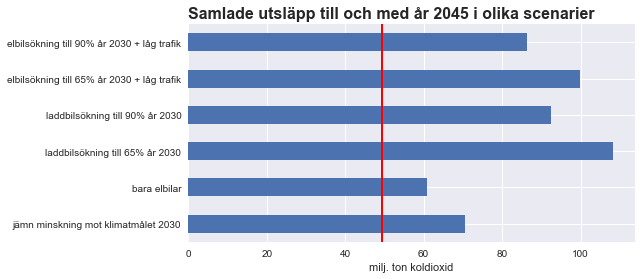

In [28]:
title = "Samlade utsläpp till och med år 2045 i olika scenarier"
ax = df_co2_proj[df_co2_proj.index >= co2_budget_year].sum().plot.barh(title=title)
ax.set_xlabel("milj. ton koldioxid")
ax.axvline(co2_budget_cars, color="red")

plt.show()

## Hade budgeten hållit om vi utsläppsminskningen kommit i gång tidigare?

Det klimatpolitiska ramverket, som slår fast 2030- och 2045-målen för transportsektorn, antogs år 2017. 
Hur mycket mindre hade personbilarna släppt ut om utsläppen börjat minska i jämn takt mot 2030-målet från och med 2017?


Om vi, hypotetiskt, hade lyckats börja reducera utläppen redan från och med år 2017 i jämn takt mot 2030-målet 
hade utsläppen i dag redan minskat med -26% 
(i verkligheten har vi minskat med -13%). 

Om vi antar att utsläppen från och med i år börjar minskat i jämn takt mot 2030 kommer vi ändå, på vägen, 
ha släppt ut 10.0 miljoner ton koldioxid mer.


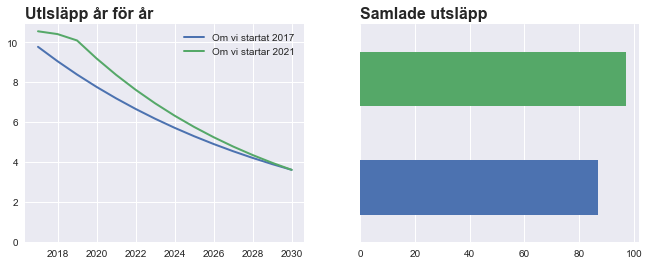

In [29]:
y0 = 2017
co2_y0 = co2_observed.loc[y0]
n_years_from_y0_to_2030 = 2031 - y0
yearly_change_to_meet_2030_from_y0 = pow(co2_klimatmålet_2030 / co2_y0, 1 / n_years_from_y0_to_2030)

s_post_2030 = df_co2_proj["jämn minskning mot klimatmålet 2030"].loc[range(2031, 2045 + 1)]

s_reduction_from_y0 = (pd.Series([yearly_change_to_meet_2030_from_y0] * n_years_from_y0_to_2030).cumprod() 
                       * co2_y0) #.append(s_post_2030)

start_y0_label = f"Om vi startat {y0}"
start_now_label = "Om vi startar 2021"

s_reduction_from_y0.index = range(y0, 2030 + 1)
s_reduction_from_now = co2_observed.loc[range(y0, 2020)]\
                         .append(df_co2_proj["jämn minskning mot klimatmålet 2030"])\
                        .loc[range(y0, 2030 + 1)]
df_reduction_scen = pd.concat([
    s_reduction_from_y0.rename(start_y0_label),
    s_reduction_from_now.rename(start_now_label),
], axis=1)


fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.set_size_inches(11,4)

df_reduction_scen.plot(ax=ax_left)
ax_left.set_ylim(0)
ax_left.set_title("Utlsläpp år för år")

colors = [x.get_color() for x in ax_left.get_lines()]
df_reduction_scen.sum().plot.barh(ax=ax_right, color=colors)
ax_right.get_yaxis().set_ticks([])
ax_right.set_title("Samlade utsläpp")


rel_diff_2020 = df_reduction_scen.loc[2020][start_y0_label] / df_reduction_scen.loc[2017][start_now_label] - 1
rel_diff_2020_actual = df_reduction_scen.loc[2020][start_now_label] / df_reduction_scen.loc[2017][start_now_label] - 1
cum_emissions_2030 = df_reduction_scen.sum()
abs_diff_2030 = cum_emissions_2030.loc[start_now_label] - cum_emissions_2030.loc[start_y0_label]

md(f"""
Om vi, hypotetiskt, hade lyckats börja reducera utläppen redan från och med år {y0} i jämn takt mot 2030-målet 
hade utsläppen i dag redan minskat med {rel_diff_2020:.0%} 
(i verkligheten har vi minskat med {rel_diff_2020_actual:.0%}). 

Om vi antar att utsläppen från och med i år börjar minskat i jämn takt mot 2030 kommer vi ändå, på vägen, 
ha släppt ut {abs_diff_2030:.3} miljoner ton koldioxid mer.
""")

Om utsläppsminskning kommit i gång redan år 2017 hade vi även år 2030, precis, legat inom budget.

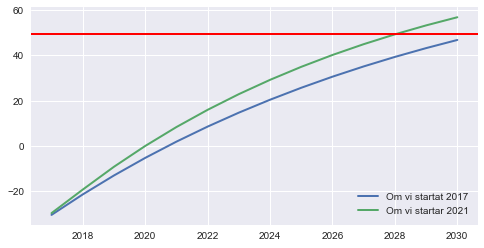

In [30]:
cum_emissions_2020 = df_reduction_scen.cumsum().loc[2020][start_now_label]

title = "Kumulativa utsläpp"
ax = (df_reduction_scen.cumsum() - cum_emissions_2020).plot()
ax.axhline(co2_budget_cars, color="red")
plt.show()